# Pricing European options

Consider a two-step binomial tree. A non-dividend paying stock price starts at \\$50, and in each of the two time steps, the stock may go up by 20 percent or go down by 20 percent. We suppose that the risk-free rate is 5 percent per annum and the time to maturity T is 2 years. We would like to find the value of an European put option with a strike price K of $52.

In [1]:
import math

r = 0.05
T = 2
t = T/2
u = 1.2
d = 0.8

q = (math.exp(r*t)-d)/(u-d)

In [2]:
print('q is', q)

q is 0.6281777409400603


## Writing the StockOption base class

In [3]:
import math

""" 
Stores common attributes of a stock option 
"""
class StockOption(object):
    def __init__(
        self, S0, K, r=0.05, T=1, N=2, pu=0, pd=0, 
        div=0, sigma=0, is_put=False, is_am=False):
        """
        Initialize the stock option base class.
        Defaults to European call unless specified.

        :param S0: initial stock price
        :param K: strike price
        :param r: risk-free interest rate
        :param T: time to maturity
        :param N: number of time steps
        :param pu: probability at up state
        :param pd: probability at down state
        :param div: Dividend yield
        :param is_put: True for a put option,
                False for a call option
        :param is_am: True for an American option,
                False for a European option
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.STs = [] # Declare the stock prices tree

        """ Optional parameters used by derived classes """
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am

    @property
    def dt(self):
        """ Single time step, in years """
        return self.T/float(self.N)

    @property
    def df(self):
        """ The discount factor """
        return math.exp(-(self.r-self.div)*self.dt)  

## A class for European options using a binomial tree

In [4]:
    import math
    import numpy as np
    from decimal import Decimal

    """ 
    Price a European option by the binomial tree model 
    """
    class BinomialEuropeanOption(StockOption):

        def setup_parameters(self):
            # Required calculations for the model
            self.M = self.N+1  # Number of terminal nodes of tree
            self.u = 1+self.pu  # Expected value in the up state
            self.d = 1-self.pd  # Expected value in the down state
            self.qu = (math.exp(
                (self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
            self.qd = 1-self.qu

        def init_stock_price_tree(self):
            # Initialize terminal price nodes to zeros
            self.STs = np.zeros(self.M)

            # Calculate expected stock prices for each node
            for i in range(self.M):
                self.STs[i] = self.S0 * \
                    (self.u**(self.N-i)) * (self.d**i)

        def init_payoffs_tree(self):
            """
            Returns the payoffs when the option 
            expires at terminal nodes
            """ 
            if self.is_call:
                return np.maximum(0, self.STs-self.K)
            else:
                return np.maximum(0, self.K-self.STs)

        def traverse_tree(self, payoffs):
            """
            Starting from the time the option expires, traverse
            backwards and calculate discounted payoffs at each node
            """
            for i in range(self.N):
                payoffs = (payoffs[:-1]*self.qu + 
                           payoffs[1:]*self.qd)*self.df

            return payoffs

        def begin_tree_traversal(self):
            payoffs = self.init_payoffs_tree()
            return self.traverse_tree(payoffs)

        def price(self):
            """ Entry point of the pricing implementation """
            self.setup_parameters()
            self.init_stock_price_tree()
            payoffs = self.begin_tree_traversal()
            
            # Option value converges to first node
            return payoffs[0]

In [5]:
eu_option = BinomialEuropeanOption(
    50, 52, r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True)

In [6]:
print('European put option price is:', eu_option.price())

European put option price is: 4.1926542806038585


## A class for American options using a binomial tree

In [7]:
import math
import numpy as np

""" 
Price a European or American option by the binomial tree 
"""
class BinomialTreeOption(StockOption):

    def setup_parameters(self):
        self.u = 1+self.pu  # Expected value in the up state
        self.d = 1-self.pd  # Expected value in the down state
        self.qu = (math.exp(
            (self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1-self.qu

    def init_stock_price_tree(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate(
                (prev_branches*self.u, 
                 [prev_branches[-1]*self.d]))
            self.STs.append(st) # Add nodes at each time step

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N]-self.K)
        else:
            return np.maximum(0, self.K-self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])

    def traverse_tree(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1]*self.qu + 
                       payoffs[1:]*self.qd)*self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs,i)

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)

    def price(self):
        """  The pricing implementation """
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [8]:
am_option = BinomialTreeOption(50, 52, 
    r=0.05, T=2, N=2, pu=0.2, pd=0.2, is_put=True, is_am=True)

In [9]:
print("American put option price is:", am_option.price())

American put option price is: 5.089632474198373


## The Cox-Ross-Rubinstein model

### A class for Cox-Ross-Rubinstein binomial tree option pricing model

In [10]:
import math

""" 
Price an option by the binomial CRR model 
"""
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = (math.exp((self.r-self.div)*self.dt) - 
                   self.d)/(self.u-self.d)
        self.qd = 1-self.qu

Consider again the two-step binomial tree. The non-dividend paying stock has a current price of \\$50 and a volatility of 30 percent. Suppose that the risk-free rate is 5 percent per annum and the time to maturity T is 2 years. We would like to find the value of an European put option with a strike price K of \\$52 by the CRR model:


In [11]:
eu_option = BinomialCRROption(
    50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)

In [12]:
print('European put:', eu_option.price())

European put: 6.245708445206436


In [13]:
am_option = BinomialCRROption(
    50, 52, r=0.05, T=2, N=2, 
    sigma=0.3, is_put=True, is_am=True)

In [14]:
print('American put option price is:', am_option.price())

American put option price is: 7.428401902704834


## Using a Leisen-Reimer (LR) tree

### A class for LR binomial tree option pricing model

In [15]:
import math

""" 
Price an option by the Leisen-Reimer tree
"""
class BinomialLROption(BinomialTreeOption):

    def setup_parameters(self):
        odd_N = self.N if (self.N%2 == 0) else (self.N+1)
        d1 = (math.log(self.S0/self.K) +
              ((self.r-self.div) +
               (self.sigma**2)/2.)*self.T)/\
            (self.sigma*math.sqrt(self.T))
        d2 = (math.log(self.S0/self.K) +
              ((self.r-self.div) -
               (self.sigma**2)/2.)*self.T)/\
            (self.sigma * math.sqrt(self.T))

        pbar = self.pp_2_inversion(d1, odd_N)
        self.p = self.pp_2_inversion(d2, odd_N)
        self.u = 1/self.df * pbar/self.p
        self.d = (1/self.df-self.p*self.u)/(1-self.p)
        self.qu = self.p
        self.qd = 1-self.p

    def pp_2_inversion(self, z, n):
        return .5 + math.copysign(1, z)*\
            math.sqrt(.25 - .25*
                math.exp(
                    -((z/(n+1./3.+.1/(n+1)))**2.)*(n+1./6.)
                )
            )

In [16]:
eu_option = BinomialLROption(
    50, 52, r=0.05, T=2, N=4, sigma=0.3, is_put=True)

In [17]:
print("European put:", eu_option.price())

European put: 5.878650106601964


In [18]:
am_option = BinomialLROption(50, 52, 
    r=0.05, T=2, N=4, sigma=0.3, is_put=True, is_am=True)

In [19]:
print('American put:', am_option.price())

American put: 6.763641952939979


# The Greeks for free

## A class for greeks with the LR binomial tree

In [20]:
import numpy as np

""" 
Compute option price, delta and gamma by the LR tree 
"""
class BinomialLRWithGreeks(BinomialLROption):

    def new_stock_price_tree(self):
        """
        Creates an additional layer of nodes to our
        original stock price tree
        """
        self.STs = [np.array([self.S0*self.u/self.d,
                              self.S0,
                              self.S0*self.d/self.u])]

        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches*self.u,
                                 [prev_branches[-1]*self.d]))
            self.STs.append(st)

    def price(self):
        self.setup_parameters()
        self.new_stock_price_tree()
        payoffs = self.begin_tree_traversal()

        # Option value is now in the middle node at t=0
        option_value = payoffs[len(payoffs)//2]

        payoff_up = payoffs[0]
        payoff_down = payoffs[-1]
        S_up = self.STs[0][0]
        S_down = self.STs[0][-1]
        dS_up = S_up - self.S0
        dS_down = self.S0 - S_down

        # Calculate delta value
        dS = S_up - S_down
        dV = payoff_up - payoff_down
        delta = dV/dS

        # calculate gamma value
        gamma = ((payoff_up-option_value)/dS_up - 
                 (option_value-payoff_down)/dS_down) / \
            ((self.S0+S_up)/2. - (self.S0+S_down)/2.)

        return option_value, delta, gamma

In [21]:
eu_call = BinomialLRWithGreeks(50, 52, r=0.05, T=2, N=300, sigma=0.3)
results = eu_call.price()

In [22]:
print('European call values')
print('Price: %s\nDelta: %s\nGamma: %s' % results)

European call values
Price: 9.69546807138366
Delta: 0.6392477816643529
Gamma: 0.01764795890533088


In [23]:
eu_put = BinomialLRWithGreeks(
    50, 52, r=0.05, T=2, N=300, sigma=0.3, is_put=True)
results = eu_put.price()

In [24]:
print('European put values')
print('Price: %s\nDelta: %s\nGamma: %s' % results)

European put values
Price: 6.747013809252746
Delta: -0.3607522183356649
Gamma: 0.0176479589053312


# Trinomial trees in options pricing

##  A class for the trinomial tree options pricing model

In [25]:
import math
import numpy as np

class TrinomialTreeOption(BinomialTreeOption):

    def setup_parameters(self):
        """ Required calculations for the model """
        self.u = math.exp(self.sigma*math.sqrt(2.*self.dt))
        self.d = 1/self.u
        self.m = 1
        self.qu = ((math.exp((self.r-self.div) *
                             self.dt/2.) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2
        self.qd = ((math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp((self.r-self.div) *
                             self.dt/2.)) /
                   (math.exp(self.sigma *
                             math.sqrt(self.dt/2.)) -
                    math.exp(-self.sigma *
                             math.sqrt(self.dt/2.))))**2.

        self.qm = 1 - self.qu - self.qd

    def init_stock_price_tree(self):
        # Initialize a 2D tree at t=0
        self.STs = [np.array([self.S0])]

        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate(
                (prev_nodes*self.u, [prev_nodes[-1]*self.m,
                                     prev_nodes[-1]*self.d]))
            self.STs.append(self.ST)

    def traverse_tree(self, payoffs):
        # Traverse the tree backwards 
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu +
                       payoffs[1:-1] * self.qm +
                       payoffs[2:] * self.qd) * self.df

            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs,i)

        return payoffs

In [26]:
eu_put = TrinomialTreeOption(
    50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)

In [27]:
print('European put:', eu_put.price())

European put: 6.573565269142496


In [28]:
am_option = TrinomialTreeOption(50, 52, 
    r=0.05, T=2, N=2, sigma=0.3, is_put=True, is_am=True)

In [29]:
print('American put:', am_option.price())

American put: 7.161349217272585


# Lattices in options pricing

## A class for CRR binomial lattice option pricing model

In [30]:
import numpy as np

class BinomialCRRLattice(BinomialCRROption):

    def setup_parameters(self):
        super(BinomialCRRLattice, self).setup_parameters()
        self.M = 2*self.N + 1

    def init_stock_price_tree(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0 * self.u**self.N

        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d

    def init_payoffs_tree(self):
        odd_nodes = self.STs[::2]  # Take odd nodes only
        if self.is_call:
            return np.maximum(0, odd_nodes-self.K)
        else:
            return np.maximum(0, self.K-odd_nodes)

    def check_early_exercise(self, payoffs, node):
        self.STs = self.STs[1:-1]  # Shorten ends of the list
        odd_STs = self.STs[::2]  # Take odd nodes only
        if self.is_call:
            return np.maximum(payoffs, odd_STs-self.K)
        else:
            return np.maximum(payoffs, self.K-odd_STs)

In [31]:
eu_option = BinomialCRRLattice(
    50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)

In [32]:
print('European put:', eu_option.price())

European put: 6.245708445206432


In [33]:
am_option = BinomialCRRLattice(50, 52, 
    r=0.05, T=2, N=2, sigma=0.3, is_put=True, is_am=True)

In [34]:
print("American put:", am_option.price())

American put: 7.428401902704828


## Writing the TrinomialLattice class

In [35]:
import numpy as np

""" 
Price an option by the trinomial lattice 
"""
class TrinomialLattice(TrinomialTreeOption):

    def setup_parameters(self):
        super(TrinomialLattice, self).setup_parameters()
        self.M = 2*self.N + 1

    def init_stock_price_tree(self):
        self.STs = np.zeros(self.M)
        self.STs[0] = self.S0 * self.u**self.N

        for i in range(self.M)[1:]:
            self.STs[i] = self.STs[i-1]*self.d

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs-self.K)
        else:
            return np.maximum(0, self.K-self.STs)

    def check_early_exercise(self, payoffs, node):
        self.STs = self.STs[1:-1]  # Shorten ends of the list
        if self.is_call:
            return np.maximum(payoffs, self.STs-self.K)
        else:
            return np.maximum(payoffs, self.K-self.STs)

In [36]:
eu_option = TrinomialLattice(
    50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)
print('European put:', eu_option.price())

European put: 6.573565269142496


In [37]:
am_option = TrinomialLattice(50, 52, 
    r=0.05, T=2, N=2, sigma=0.3, is_put=True, is_am=True)
print('American put:', am_option.price())

American put: 7.161349217272585


# Finite differences in options pricing

## Writing the Finite Differences base class

In [38]:
from abc import ABC, abstractmethod
import numpy as np

""" 
Base class for sharing 
attributes and functions of FD 
"""
class FiniteDifferences(object):

    def __init__(
        self, S0, K, r=0.05, T=1, 
        sigma=0, Smax=1, M=1, N=1, is_put=False
    ):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = M, N
        self.is_call = not is_put

        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        self.boundary_conds = np.linspace(0, Smax, self.M+1)

    @property
    def dS(self):
        return self.Smax/float(self.M)

    @property
    def dt(self):
        return self.T/float(self.N)

    @abstractmethod
    def setup_boundary_conditions(self):
        raise NotImplementedError('Implementation required!')

    @abstractmethod
    def setup_coefficients(self):
        raise NotImplementedError('Implementation required!')

    @abstractmethod
    def traverse_grid(self):
        """  
        Iterate the grid backwards in time 
        """
        raise NotImplementedError('Implementation required!')

    @abstractmethod
    def interpolate(self):
        """
        Use piecewise linear interpolation on the initial
        grid column to get the closest price at S0.
        """
        return np.interp(
            self.S0, self.boundary_conds, self.grid[:,0])

    def price(self):
        self.setup_boundary_conditions()
        self.setup_coefficients()
        self.traverse_grid()
        return self.interpolate()

### A class for pricing European options using explicit method of finite differences

In [39]:
import numpy as np

""" 
Explicit method of Finite Differences 
"""
class FDExplicitEu(FiniteDifferences):

    def setup_boundary_conditions(self):
        if self.is_call:
            self.grid[:,-1] = np.maximum(
                0, self.boundary_conds - self.K)
            self.grid[-1,:-1] = (self.Smax-self.K) * \
                np.exp(-self.r*self.dt*(self.N-self.j_values))
        else:
            self.grid[:,-1] = np.maximum(
                0, self.K-self.boundary_conds)
            self.grid[0,:-1] = (self.K-self.Smax) * \
                np.exp(-self.r*self.dt*(self.N-self.j_values))

    def setup_coefficients(self):
        self.a = 0.5*self.dt*((self.sigma**2) *
                              (self.i_values**2) -
                              self.r*self.i_values)
        self.b = 1 - self.dt*((self.sigma**2) *
                              (self.i_values**2) +
                              self.r)
        self.c = 0.5*self.dt*((self.sigma**2) *
                              (self.i_values**2) +
                              self.r*self.i_values)

    def traverse_grid(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[2:]:
                self.grid[i,j] = \
                    self.a[i]*self.grid[i-1,j+1] +\
                    self.b[i]*self.grid[i,j+1] + \
                    self.c[i]*self.grid[i+1,j+1]

Consider the example of an European put option. The underlying stock price is $50 with a volatility of 40 percent. The strike price of the put option is $50 with an expiration time of 5 months. The risk-free rate is 10 percent.

We can price the option using the explicit method with a Smax value of 100, an M value of 100, and a N value of 1,000:

In [40]:
option = FDExplicitEu(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=100, N=1000, is_put=True)
print(option.price())

4.072882278148043


What happens when other values of M and N are chosen improperly?

In [41]:
option = FDExplicitEu(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=80, N=100, is_put=True)
print(option.price())

-8.109445694129245e+35


### A class for pricing European options using the implicit method of finite differences

In [42]:
import numpy as np
import scipy.linalg as linalg

""" 
Explicit method of Finite Differences 
"""
class FDImplicitEu(FDExplicitEu):

    def setup_coefficients(self):
        self.a = 0.5*(self.r*self.dt*self.i_values -
                      (self.sigma**2)*self.dt*\
                          (self.i_values**2))
        self.b = 1 + \
                 (self.sigma**2)*self.dt*\
                    (self.i_values**2) + self.r*self.dt
        self.c = -0.5*(self.r*self.dt*self.i_values +
                       (self.sigma**2)*self.dt*\
                           (self.i_values**2))
        self.coeffs = np.diag(self.a[2:self.M],-1) + \
                      np.diag(self.b[1:self.M]) + \
                      np.diag(self.c[1:self.M-1],1)

    def traverse_grid(self):
        """ Solve using linear systems of equations """
        P, L, U = linalg.lu(self.coeffs)
        aux = np.zeros(self.M-1)

        for j in reversed(range(self.N)):
            aux[0] = np.dot(-self.a[1], self.grid[0, j])
            x1 = linalg.solve(L, self.grid[1:self.M, j+1]+aux)
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

In [43]:
option = FDImplicitEu(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=100, N=1000, is_put=True)
print(option.price())

4.071594188049893


In [44]:
option = FDImplicitEu(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=80, N=100, is_put=True)
print(option.price())

4.063684691731648


### A class for pricing European options using the Crank-Nicolson method of finite differences

In [45]:
import numpy as np
import scipy.linalg as linalg

""" 
Crank-Nicolson method of Finite Differences 
"""
class FDCnEu(FDExplicitEu):

    def setup_coefficients(self):
        self.alpha = 0.25*self.dt*(
            (self.sigma**2)*(self.i_values**2) - \
            self.r*self.i_values)
        self.beta = -self.dt*0.5*(
            (self.sigma**2)*(self.i_values**2) + self.r)
        self.gamma = 0.25*self.dt*(
            (self.sigma**2)*(self.i_values**2) +
            self.r*self.i_values)
        self.M1 = -np.diag(self.alpha[2:self.M], -1) + \
                  np.diag(1-self.beta[1:self.M]) - \
                  np.diag(self.gamma[1:self.M-1], 1)
        self.M2 = np.diag(self.alpha[2:self.M], -1) + \
                  np.diag(1+self.beta[1:self.M]) + \
                  np.diag(self.gamma[1:self.M-1], 1)

    def traverse_grid(self):
        """ Solve using linear systems of equations """
        P, L, U = linalg.lu(self.M1)

        for j in reversed(range(self.N)):
            x1 = linalg.solve(
                L, np.dot(self.M2, self.grid[1:self.M, j+1]))
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2

In [46]:
option = FDCnEu(50, 50, r=0.1, T=5./12.,
    sigma=0.4, Smax=100, M=100, N=1000, is_put=True)
print(option.price())

4.072238354486825


In [47]:
option = FDCnEu(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=80, N=100, is_put=True)
print(option.price())

4.070145703042844


## Pricing exotic barrier options

### A down-and-out option

In [48]:
import numpy as np

"""
Price a down-and-out option by the Crank-Nicolson
method of finite differences.
"""
class FDCnDo(FDCnEu):

    def __init__(
        self, S0, K, r=0.05, T=1, sigma=0, 
        Sbarrier=0, Smax=1, M=1, N=1, is_put=False
    ):
        super(FDCnDo, self).__init__(
            S0, K, r=r, T=T, sigma=sigma,
            Smax=Smax, M=M, N=N, is_put=is_put
        )
        self.barrier = Sbarrier
        self.boundary_conds = \
            np.linspace(Sbarrier, Smax, M+1)
        self.i_values = self.boundary_conds/self.dS

    @property
    def dS(self):
        return (self.Smax-self.barrier)/float(self.M)

In [49]:
option = FDCnDo(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Sbarrier=40, Smax=100, M=120, N=500)
print(option.price())

5.491560552934787


In [50]:
option = FDCnDo(50, 50, r=0.1, T=5./12., sigma=0.4, 
    Sbarrier=40, Smax=100, M=120, N=500, is_put=True)
print(option.price())

0.5413635028954449


## Pricing American options with finite differences

### A class for pricing American options using the Crank-Nicolson method of finite differences

In [51]:
import numpy as np
import sys

""" 
Price an American option by the Crank-Nicolson method 
"""
class FDCnAm(FDCnEu):

    def __init__(self, S0, K, r=0.05, T=1, sigma=0, 
            Smax=1, M=1, N=1, omega=1, tol=0, is_put=False):
        super(FDCnAm, self).__init__(S0, K, r=r, T=T, 
            sigma=sigma, Smax=Smax, M=M, N=N, is_put=is_put)
        self.omega = omega
        self.tol = tol
        self.i_values = np.arange(self.M+1)
        self.j_values = np.arange(self.N+1)

    def setup_boundary_conditions(self):
        if self.is_call:
            self.payoffs = np.maximum(0, 
                self.boundary_conds[1:self.M]-self.K)
        else:
            self.payoffs = np.maximum(0, 
                self.K-self.boundary_conds[1:self.M])

        self.past_values = self.payoffs
        self.boundary_values = self.K * np.exp(
                -self.r*self.dt*(self.N-self.j_values))
        
    def calculate_payoff_start_boundary(self, rhs, old_values):
        payoff = old_values[0] + \
            self.omega/(1-self.beta[1]) * \
                (rhs[0] - \
                 (1-self.beta[1])*old_values[0] + \
                 self.gamma[1]*old_values[1])

        return max(self.payoffs[0], payoff)      
    
    def calculate_payoff_end_boundary(self, rhs, old_values, new_values):
        payoff = old_values[-1] + \
            self.omega/(1-self.beta[-2]) * \
                (rhs[-1] + \
                 self.alpha[-2]*new_values[-2] - \
                 (1-self.beta[-2])*old_values[-1])

        return max(self.payoffs[-1], payoff)
    
    def calculate_payoff(self, k, rhs, old_values, new_values):
        payoff = old_values[k] + \
            self.omega/(1-self.beta[k+1]) * \
                (rhs[k] + \
                 self.alpha[k+1]*new_values[k-1] - \
                 (1-self.beta[k+1])*old_values[k] + \
                 self.gamma[k+1]*old_values[k+1])

        return max(self.payoffs[k], payoff)

    def traverse_grid(self):
        """ Solve using linear systems of equations """
        aux = np.zeros(self.M-1)
        new_values = np.zeros(self.M-1)

        for j in reversed(range(self.N)):
            aux[0] = self.alpha[1]*(self.boundary_values[j] +
                                    self.boundary_values[j+1])
            rhs = np.dot(self.M2, self.past_values) + aux
            old_values = np.copy(self.past_values)
            error = sys.float_info.max

            while self.tol < error:
                new_values[0] = \
                    self.calculate_payoff_start_boundary(
                        rhs, old_values)            

                for k in range(self.M-2)[1:]:
                    new_values[k] = \
                        self.calculate_payoff(
                            k, rhs, old_values, new_values)                    

                new_values[-1] = \
                    self.calculate_payoff_end_boundary(
                        rhs, old_values, new_values)

                error = np.linalg.norm(new_values-old_values)
                old_values = np.copy(new_values)

                self.past_values = np.copy(new_values)

        self.values = np.concatenate(
            ([self.boundary_values[0]], new_values, [0]))

    def interpolate(self):
        # Use linear interpolation on final values as 1D array
        return np.interp(
            self.S0, self.boundary_conds, self.values)

Let's price an American call-and-put option with an underlying asset price of 50 and volatility of 40 percent, a strike price of 50, a risk-free rate of 10 percent, and
an expiration date of 5 months. We choose a <i>S<sub>max</sub></i> value of 100, <i>M</i> as 100, <i>N</i> as 42, an
`omega` parameter value of 1.2, and a tolerance value of 0.001:

In [52]:
option = FDCnAm(50, 50, r=0.1, T=5./12., 
    sigma=0.4, Smax=100, M=100, N=42, omega=1.2, tol=0.001)
print(option.price())

6.108682815392218


In [53]:
option = FDCnAm(50, 50, r=0.1, T=5./12., sigma=0.4, Smax=100, 
    M=100, N=42, omega=1.2, tol=0.001, is_put=True)
print(option.price())

4.2777642293837355


# Implied volatilities of AAPL American put option

In [54]:
"""
Get implied volatilities from a Leisen-Reimer binomial
tree using the bisection method as the numerical procedure.
"""
class ImpliedVolatilityModel(object):

    def __init__(self, S0, r=0.05, T=1, div=0, 
                 N=1, is_put=False):
        self.S0 = S0
        self.r = r
        self.T = T
        self.div = div
        self.N = N
        self.is_put = is_put

    def option_valuation(self, K, sigma):
        """ Use the binomial Leisen-Reimer tree """
        lr_option = BinomialLROption(
            self.S0, K, r=self.r, T=self.T, N=self.N, 
            sigma=sigma, div=self.div, is_put=self.is_put
        )
        return lr_option.price()

    def get_implied_volatilities(self, Ks, opt_prices):
        impvols = []
        for i in range(len(strikes)):
            # Bind f(sigma) for use by the bisection method
            f = lambda sigma: \
                self.option_valuation(Ks[i], sigma)-\
                opt_prices[i]
            impv = bisection(f, 0.01, 0.99, 0.0001, 100)[0]
            impvols.append(impv)

        return impvols

In [55]:
def bisection(f, a, b, tol=0.1, maxiter=10):
    """
    :param f: The function to solve
    :param a: The x-axis value where f(a)<0
    :param b: The x-axis value where f(b)>0
    :param tol: The precision of the solution
    :param maxiter: Maximum number of iterations
    :return: The x-axis value of the root,
                number of iterations used
    """
    c = (a+b)*0.5  # Declare c as the midpoint ab
    n = 1  # Start with 1 iteration
    while n <= maxiter:
        c = (a+b)*0.5
        if f(c) == 0 or abs(a-b)*0.5 < tol:
            # Root is found or is very close
            return c, n

        n += 1
        if f(c) < 0:
            a = c
        else:
            b = c
                
    return c, n

In [56]:
strikes = [75, 80, 85, 90, 92.5, 95, 97.5, 
           100, 105, 110, 115, 120, 125]
put_prices = [0.16, 0.32, 0.6, 1.22, 1.77, 2.54, 3.55, 
              4.8, 7.75, 11.8, 15.96, 20.75, 25.81]

In [57]:
model = ImpliedVolatilityModel(
    99.62, r=0.0248, T=78/365., div=0.0182, N=77, is_put=True)
impvols_put = model.get_implied_volatilities(strikes, put_prices)

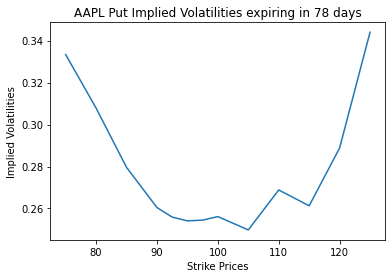

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(strikes, impvols_put)
plt.xlabel('Strike Prices')
plt.ylabel('Implied Volatilities')
plt.title('AAPL Put Implied Volatilities expiring in 78 days')
plt.show()